# Smart Energy Supply Scheduling for Green Telecom Challenge
The project emphasizes the importance of optimizing energy use in the telecom sector, contributing to cost reduction and environmental sustainability goals.

## Project Overview
The Smart Energy Supply Scheduling for Green Telecom Challenge, organized by the International Telecommunication Union (ITU), aims to develop machine learning models to optimize the utilization of various energy sources for powering mobile networks. The goal is to minimize energy costs while ensuring the battery's remaining capacity meets a set threshold. The energy sources considered are grid power, solar power, and diesel generators, with a focus on integrating these sources efficiently to reduce overall costs and carbon emissions.

## Problem Statement
Participants are tasked with designing an energy supply strategy that specifies when and which energy sources (grid, solar, diesel) to use. The strategy must minimize the total energy supply costs while maintaining the battery’s state of charge (SOC) above a defined discharge threshold. The challenge involves predicting daily solar energy generation and determining optimal usage strategies for the available energy sources based on historical data.

## Dataset
The [dataset](https://zindi.africa/competitions/smart-energy-supply-scheduling-for-green-telecom/data) provided for this challenge is divided into the following key files:
- _Energy Consumption Data:_ Hourly data detailing the energy consumption of base stations.
- _Site Information and Grid Outage Data:_ Information on site configuration, battery capacity, grid outage plans, and diesel power output.
- _Solar Power and Weather Conditions Data:_ Hourly solar power statistics and weather conditions affecting solar energy generation.
- _Sample Submission File:_ Template for the expected format of submissions.


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from scipy.stats import pearsonr

In [2]:
# display all columns in a dataframe
pd.set_option('display.max_columns', None)

In [3]:
# Load files into a pandas dataframe
energy_consumption = pd.read_csv('/kaggle/input/smart-energy-supply/energy consumption.csv')
site_info = pd.read_csv('/kaggle/input/smart-energy-supply/site information and grid outage.csv')
ss = pd.read_csv('/kaggle/input/smart-energy-supply/SampleSubmission.csv')
solar_power = pd.read_csv('/kaggle/input/smart-energy-supply/solar power and weather condition.csv')

In [4]:
# Let’s observe the shape of our datasets.
print('Energy Consumption shape :', energy_consumption.shape)
print('Site Information shape :', site_info.shape)
print('Solar Power shape :', solar_power.shape)

Energy Consumption shape : (14400, 4)
Site Information shape : (10, 10)
Solar Power shape : (14400, 12)


In [5]:
site_info.columns

Index(['Site Id', 'diesel power(kW)', 'battery capacity (Ah)',
       'rated voltage（V）', 'battery charge coefficient',
       'battery discharge coefficient', 'init SOC', 'DOD', 'grid power(kW)',
       'grid outage plan'],
      dtype='object')

In [6]:
energy_consumption.head()

,Site Name,Day,Hour,Total Energy(kWh)
0,site10,1,0,3.91
1,site10,1,1,3.99
2,site10,1,2,3.98
3,site10,1,3,3.99
4,site10,1,4,3.97


In [7]:
energy_consumption.columns

Index(['Site Name', 'Day', 'Hour', 'Total Energy(kWh)'], dtype='object')

In [8]:
solar_power.head()

,Site Name,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh)
0,site1,1,0,138.12,0.00,0.00,0.00,59.05,0.00,0.0,0.0,0.0
1,site1,1,1,125.23,0.00,0.00,0.00,62.04,0.00,0.0,0.0,0.0
2,site1,1,2,116.75,0.00,0.00,0.00,65.29,0.00,0.0,0.0,0.0
3,site1,1,3,97.86,0.00,0.00,0.00,63.05,0.00,0.0,0.0,0.0
4,site1,1,4,85.22,30.97,204.94,48.05,57.81,32.22,0.0,33.7,0.0


In [9]:
solar_power.columns

Index(['Site Name', 'Day', 'Hour', 'Solar Zenith Angle', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI',
       'GHI', 'Energy Output(kWh)'],
      dtype='object')

In [10]:
ss.head()

,site name,time,grid,diesel,solar
0,site1,0,True,True,True
1,site1,1,True,True,True
2,site1,2,True,True,True
3,site1,3,True,True,True
4,site1,4,True,True,True


In [11]:
energy_consumption.isnull().sum()

Site Name            0
Day                  0
Hour                 0
Total Energy(kWh)    0
dtype: int64

In [12]:
solar_power.isnull().sum()


Site Name             0
Day                   0
Hour                  0
Solar Zenith Angle    0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Relative Humidity     0
DHI                   0
DNI                   0
GHI                   0
Energy Output(kWh)    0
dtype: int64

In [13]:
site_info.isnull().sum()

Site Id                          0
diesel power(kW)                 0
battery capacity (Ah)            0
rated voltage（V）                 0
battery charge coefficient       0
battery discharge coefficient    0
init SOC                         0
DOD                              0
grid power(kW)                   0
grid outage plan                 0
dtype: int64

In [14]:
# Merge datasets
df_merged = solar_power.merge(energy_consumption, on=['Site Name', 'Day', 'Hour'], how='left')
df = pd.merge(df_merged, site_info, left_on='Site Name', right_on='Site Id')

df.head()

,Site Name,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh),Total Energy(kWh),Site Id,diesel power(kW),battery capacity (Ah),rated voltage（V）,battery charge coefficient,battery discharge coefficient,init SOC,DOD,grid power(kW),grid outage plan
0,site1,1,0,138.12,0.00,0.00,0.00,59.05,0.00,0.0,0.0,0.0,4.48,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
1,site1,1,1,125.23,0.00,0.00,0.00,62.04,0.00,0.0,0.0,0.0,4.30,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
2,site1,1,2,116.75,0.00,0.00,0.00,65.29,0.00,0.0,0.0,0.0,4.17,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
3,site1,1,3,97.86,0.00,0.00,0.00,63.05,0.00,0.0,0.0,0.0,4.15,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
4,site1,1,4,85.22,30.97,204.94,48.05,57.81,32.22,0.0,33.7,0.0,4.32,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...


In [15]:
df_merged.columns

Index(['Site Name', 'Day', 'Hour', 'Solar Zenith Angle', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI',
       'GHI', 'Energy Output(kWh)', 'Total Energy(kWh)'],
      dtype='object')

In [16]:
# Sort DataFrame by 'Site Name' in natural order
df = df.sort_values(by='Site Name', key=lambda x: x.str.extract('(\d+)')[0].astype(int))

In [17]:
# Fill missing values
df.fillna(method='ffill', inplace=True)

/tmp/ipykernel_37/1940206128.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [18]:
df.shape

(14400, 23)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14400 entries, 0 to 2878
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Site Name                      14400 non-null  object 
 1   Day                            14400 non-null  int64  
 2   Hour                           14400 non-null  int64  
 3   Solar Zenith Angle             14400 non-null  float64
 4   Clearsky DHI                   14400 non-null  float64
 5   Clearsky DNI                   14400 non-null  float64
 6   Clearsky GHI                   14400 non-null  float64
 7   Relative Humidity              14400 non-null  float64
 8   DHI                            14400 non-null  float64
 9   DNI                            14400 non-null  float64
 10  GHI                            14400 non-null  float64
 11  Energy Output(kWh)             14400 non-null  float64
 12  Total Energy(kWh)              14400 non-null  float

In [20]:
df.describe()

,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh),Total Energy(kWh),diesel power(kW),battery capacity (Ah),rated voltage（V）,battery charge coefficient,battery discharge coefficient,init SOC,DOD,grid power(kW)
count,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.000000,14400.00000,14400.0,14400.00,1.440000e+04,14400.0,1.440000e+04,14400.000000
mean,30.500000,11.500000,92.338322,42.651233,367.844437,279.364433,63.771593,71.126381,215.681264,208.900068,2.858092,5.682772,16.040000,528.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,10.400000
std,17.318704,6.922427,44.193477,50.195074,408.866041,357.734264,20.632313,116.623891,351.401864,304.030311,4.138816,2.704091,2.613594,191.25517,0.0,0.00,2.220523e-16,0.0,2.775654e-17,2.332462
min,1.000000,0.000000,12.200000,0.000000,0.000000,0.000000,18.640000,0.000000,0.000000,0.000000,0.000000,0.600000,10.800000,300.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,8.000000
25%,15.750000,5.750000,51.160000,0.000000,0.000000,0.000000,47.865000,0.000000,0.000000,0.000000,0.000000,4.060000,12.800000,380.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,8.000000
50%,30.500000,11.500000,90.900000,0.000000,0.000000,0.000000,63.480000,0.000000,0.000000,0.000000,0.700000,4.450000,17.600000,400.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,10.000000
75%,45.250000,17.250000,132.225000,87.742500,833.260000,625.672500,80.262500,92.895000,355.987500,385.302500,4.581375,8.570000,17.600000,760.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,12.000000
max,60.000000,23.000000,178.950000,254.400000,1045.480000,1088.160000,104.000000,561.790000,1041.120000,1096.570000,26.428000,11.670000,18.000000,760.00000,54.0,0.35,1.200000e+00,0.2,1.500000e-01,14.000000


In [21]:
df.isna().sum()

Site Name                        0
Day                              0
Hour                             0
Solar Zenith Angle               0
Clearsky DHI                     0
Clearsky DNI                     0
Clearsky GHI                     0
Relative Humidity                0
DHI                              0
DNI                              0
GHI                              0
Energy Output(kWh)               0
Total Energy(kWh)                0
Site Id                          0
diesel power(kW)                 0
battery capacity (Ah)            0
rated voltage（V）                 0
battery charge coefficient       0
battery discharge coefficient    0
init SOC                         0
DOD                              0
grid power(kW)                   0
grid outage plan                 0
dtype: int64

### Exploratory Data Analysis

In [22]:
df.columns

Index(['Site Name', 'Day', 'Hour', 'Solar Zenith Angle', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI',
       'GHI', 'Energy Output(kWh)', 'Total Energy(kWh)', 'Site Id',
       'diesel power(kW)', 'battery capacity (Ah)', 'rated voltage（V）',
       'battery charge coefficient', 'battery discharge coefficient',
       'init SOC', 'DOD', 'grid power(kW)', 'grid outage plan'],
      dtype='object')

**Correlation Hypothesis**

**1. Solar Zenith Angle vs. Energy Output**
- *Hypothesis:* The solar zenith angle is negatively correlated with energy output.
- *Rationale:* As the solar zenith angle increases (meaning the sun is lower in the sky), the amount of direct solar energy reaching a site may decrease, reducing energy output.

**2. Clearsky DNI vs. Energy Output**
- *Hypothesis:* Clearsky Direct Normal Irradiance (DNI) is positively correlated with energy output.
- *Rationale:* Higher DNI, which measures the direct sunlight reaching a site without clouds, should lead to higher energy generation, assuming other factors like system efficiency remain constant.

**3. Relative Humidity vs. Energy Output**
- *Hypothesis:* Relative humidity is negatively correlated with energy output.
- *Rationale:* Higher humidity may reduce solar radiation due to increased cloud cover or atmospheric water vapor, thus lowering energy output.

**4. Battery Capacity vs. Grid Power Usage**
- *Hypothesis:* Battery capacity is negatively correlated with grid power usage.
- *Rationale:* Larger battery capacity 

**5. Battery Charge Coefficient vs. Energy Output**
- Hypothesis: The battery charge coefficient is positively correlated with energy output.
- Rationale: A higher charge coefficient might indicate more efficient storage of energy produced, which could correlate with higher energy output when needed.

**6. Diesel Power vs. Grid Outage Plan**
- *Hypothesis:* Diesel power usage is positively correlated with the frequency of grid outages.
- *Rationale:* During grid outages, diesel generators might be used more frequently to ensure continuous power supply.

**7. DNI vs. DHI (Diffuse Horizontal Irradiance)**
- *Hypothesis:* DNI is negatively correlated with DHI.
- *Rationale:* On clear days with high DNI, DHI (which measures scattered sunlight) might be lower because there is less cloud cover or atmospheric scattering.

**8. GHI (Global Horizontal Irradiance) vs. Energy Output**
- *Hypothesis:* GHI is positively correlated with energy output.
- *Rationale:* GHI represents the total amount of solar radiation received per unit area on a horizontal surface, which should directly affect the energy generated by solar panels.

**9. Solar Zenith Angle vs. Grid Power Usage**
- *Hypothesis:* The solar zenith angle is positively correlated with grid power usage.
- *Rationale:* As the zenith angle increases (especially early morning or late afternoon), solar energy generation decreases, possibly leading to increased grid power usage.

**10. Battery Discharge Coefficient vs. Total Energy Output**
- *Hypothesis:* The battery discharge coefficient is positively correlated with total energy output.
- *Rationale:* A higher discharge coefficient could indicate better battery performance, leading to higher energy availability and total energy output.

In [23]:
# Select only the numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Calculate correlations for the selected numeric columns
correlations = numeric_df.corr()

# Display correlations for specific columns of interest
correlations[['Energy Output(kWh)', 'Total Energy(kWh)', 'battery capacity (Ah)', 'grid power(kW)', 'diesel power(kW)']]

,Energy Output(kWh),Total Energy(kWh),battery capacity (Ah),grid power(kW),diesel power(kW)
Day,0.014266,-0.006183,-4.236861e-16,-1.374828e-15,-7.249799e-16
Hour,0.004755,0.123032,9.157300e-16,1.068406e-15,-7.202862e-16
Solar Zenith Angle,-0.659746,-0.070178,1.994713e-03,1.166671e-03,9.105815e-05
Clearsky DHI,0.651687,0.076483,3.758983e-03,3.096581e-03,-1.567581e-02
Clearsky DNI,0.653752,0.085668,-2.186523e-03,-9.726447e-04,6.557141e-03
Clearsky GHI,0.676147,0.077638,-6.969545e-03,-1.844959e-03,1.239192e-04
Relative Humidity,-0.505546,-0.055408,6.468604e-02,3.649859e-02,1.774047e-02
DHI,0.540707,0.058111,-6.762132e-03,-5.480888e-03,4.894861e-03
DNI,0.395003,0.038933,-1.595802e-02,-5.591174e-03,-6.786204e-03
GHI,0.567254,0.052910,-2.053226e-02,-7.610119e-03,-4.115241e-03


**1. Solar Zenith Angle vs. Energy Output**
- *Hypothesis:* Negatively correlated
- *Result:* -0.659746
- *Analysis:* This supports the hypothesis. As the solar zenith angle increases, energy output decreases.

**2. Clearsky DNI vs. Energy Output**
- *Hypothesis:* Positively correlated
- *Result:* 0.653752
- *Analysis:* This supports the hypothesis. Higher Clearsky DNI is associated with higher energy output.

**3. Relative Humidity vs. Energy Output**
- *Hypothesis:* Negatively correlated
- *Result:* -0.505546
- *Analysis:* This supports the hypothesis. Increased relative humidity correlates with decreased energy output.

**4. Battery Capacity vs. Grid Power Usage**
- *Hypothesis:* Negatively correlated
- *Result:* Not directly available in the provided correlations. 

**5. Battery Charge Coefficient vs. Energy Output**
- *Hypothesis:* Positively correlated
- *Result: Not* directly available in the provided correlations. 

**6. Diesel Power vs. Grid Outage Plan**
- *Hypothesis:* Positively correlated
- *Result:* Not directly available in the provided correlations. 

**7. DNI vs. DHI (Diffuse Horizontal Irradiance)**
- *Hypothesis:* Negatively correlated
- *Result:* Not directly available in the provided correlations. 

**8. GHI (Global Horizontal Irradiance) vs. Energy Output**
- *Hypothesis:* Positively correlated
- *Result:* 0.567254
- *Analysis:* This supports the hypothesis. Higher GHI is associated with higher energy output.

**9. Solar Zenith Angle vs. Grid Power Usage**
- *Hypothesis:* Positively correlated
- *Result:* 1.166671e-03 (very low correlation)
- *Analysis:* This does not support the hypothesis. The correlation is negligible, suggesting that solar zenith angle has little to no effect on grid power usage in this dataset.

**10. Battery Discharge Coefficient vs. Total Energy Output**
- *Hypothesis:* Positively correlated
- *Result:* Not directly available in the provided correlations. 

In [24]:
# Testing correlation between 'Energy Output(kWh)' and 'Solar Zenith Angle'
corr, p_value = pearsonr(df['Energy Output(kWh)'], df['Solar Zenith Angle'])

print(f"Correlation: {corr}, P-value: {p_value}")

Correlation: -0.6597464145670142, P-value: 0.0


['Site Name', 'Day', 'Hour', 'Solar Zenith Angle', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI', 'GHI', 'Energy Output(kWh)', 'Total Energy(kWh)', 'Site Id', 'diesel power(kW)', 'battery capacity (Ah)', 'rated voltage（V）', 'battery charge coefficient', 'battery discharge coefficient', 'init SOC', 'DOD', 'grid power(kW)', 'grid outage plan']


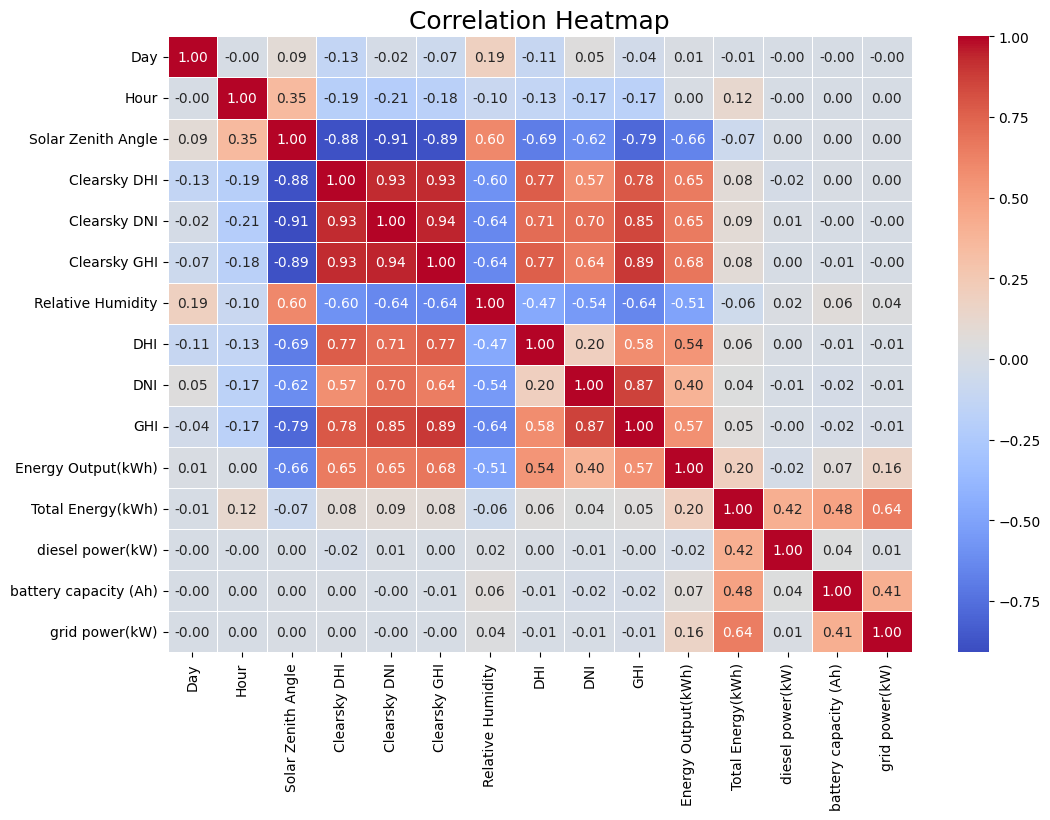

In [25]:
# Print column names to verify
print(df.columns.tolist())

# Update the exclude_columns list with verified column names
exclude_columns = ['Site Name', 'Site Id', 'rated voltage（V）', 'battery charge coefficient', 'battery discharge coefficient', 'init SOC', 'DOD']  # Use the exact name you find

# Exclude non-numeric columns and those explicitly mentioned
numeric_df = df.drop(columns=exclude_columns).select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add a title to the heatmap
plt.title('Correlation Heatmap', fontsize=18)

# Display the heatmap
plt.show()


### Feature Engineering

In [26]:
# Encode categorical variables
le = LabelEncoder()
df['Site Name'] = le.fit_transform(df['Site Name'])

In [27]:
# Create time feature
df['time'] = df['Hour'] + (df['Day'] - 1) * 24

### Separate Features and Targets

In [28]:
# Define features and target variable
X = df[['Site Name', 'time', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI', 'GHI']]
y = df['Energy Output(kWh)']

### Splitting data into Train and Test data

In [29]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training

In [30]:
# Initialize and train XGBoost Regressor
xgboost_reg = xgb.XGBRegressor(objective='reg:squarederror')
xgboost_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'alpha': [0, 10, 50]
}

In [32]:
# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.3s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.5s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=200; total time=   0.5s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.7s
[CV] END alpha=0, colsample_bytree=0.3, learning_rate=0.

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 10, 50],
                         'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [33]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

### Make Predictions

In [34]:
# Predict on the test set
y_pred = best_model.predict(X_test)

### Model Evaluation

In [35]:
# Calculate and print evaluation metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

Test RMSE: 1.8983
Test MAE: 1.1005
Test R-squared: 0.7986


### Strategy Development

In [36]:
# Predict using the best model
all_features = X.copy()
predictions = best_model.predict(all_features)

# Set threshold for decision-making
threshold = 0

# Create the submission DataFrame
submission = pd.DataFrame({
    'site': le.inverse_transform(X['Site Name']),
    'time': X['time'],
    'grid': [prediction > threshold for prediction in predictions],  # Determine grid usage based on prediction
    'diesel': [prediction > threshold for prediction in predictions],  # Determine diesel usage based on prediction
    'solar': [prediction > threshold for prediction in predictions]    # Determine solar usage based on prediction
})

# Update columns based on threshold
submission['grid'] = submission['grid'].apply(lambda x: 'TRUE' if x else 'FALSE')
submission['diesel'] = submission['diesel'].apply(lambda x: 'TRUE' if x else 'FALSE')
submission['solar'] = submission['solar'].apply(lambda x: 'TRUE' if x else 'FALSE')

# Sort by 'site' in natural order
submission['site'] = submission['site'].astype(str)
submission = submission.sort_values(by='site', key=lambda x: x.str.extract('(\d+)')[0].astype(int))

# Reset 'time' column to be continuous for each site
submission['time'] = submission.groupby('site').cumcount()

# Ensure 'site' is the first column
submission = submission[['site', 'time', 'grid', 'diesel', 'solar']]

# Save to CSV
submission.to_csv('/kaggle/working/final_submission.csv', index=False)

print(submission.head())

    site  time   grid diesel  solar
0  site1     0  FALSE  FALSE  FALSE
1  site1     1  FALSE  FALSE  FALSE
2  site1     2  FALSE  FALSE  FALSE
3  site1     3  FALSE  FALSE  FALSE
4  site1     4   TRUE   TRUE   TRUE
